In [27]:
import os, glob, re, csv
import numpy as np
import nibabel as nib
import statsmodels.api as sm
from nilearn import datasets
from nilearn.image import resample_to_img
import pandas as pd
from scipy.stats import ttest_1samp
from nilearn import plotting, datasets
import scipy.stats as stats


In [5]:
# Load the BOLD cleaned image
bold_img = nib.load('/Volumes/Passport/fmriprep/derivatives/pieMan_cleaned/sub-002/func/sub-002_task-pieman_run-1_cleaned_desc-masked_bold.nii.gz')

# Print voxel size (spatial resolution) and TR (temporal resolution)
zooms = bold_img.header.get_zooms()
print(f"Voxel size (mm): {zooms[:3]}")
print(f"TR (s): {zooms[3]}")
print(f"Shape {bold_img.shape}")

Voxel size (mm): (3.0, 3.0, 4.0)
TR (s): 1.0
Shape (65, 77, 49, 160)


In [9]:
# SET MAIN HYPERPARAMETERS
TRAIT_LABEL = "Contemplating"  

# Our 13 trait labels 
# ["Open-minded", "feeling Affectionate", "Attentive", "Assertive", "feeling Gloomy", "feeling Peaceful", "Agreeable", "Judging", "feeling Angry", "feeling Bewildered", "Impulsive", "Self-disciplined", "Contemplating"]

TRAIT_LABEL_SAVE_STRING = TRAIT_LABEL.replace(" ", "_").replace("-", "_")
STIMULUS_LABEL_SAVE_STRING = "pieman"

In [10]:
# ──────────────────────────────────────────────────────────────
# 0) PATHS & I/O
# ──────────────────────────────────────────────────────────────
root_dir  = "/Volumes/Passport/fmriprep"          # ←  same as in cleaning script
deriv_dir = os.path.join(root_dir, "derivatives") #   (don’t hard-code “subjects” yet)



# output from your behaviour-model RSA
model_rdm = np.load(
    os.path.join(deriv_dir, "RDMs_behavior", f"{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_RDM.npy"))

In [11]:
# ──────────────────────────────────────────────────────────────
# 1) SUBJECT / RUN FILTERS  (copy-paste verbatim)  ─────────────
# ──────────────────────────────────────────────────────────────
exclude_subs = {
    "sub-001","sub-021","sub-022","sub-038","sub-056","sub-068","sub-069"
}
exclude_sub_runs = {
    ("sub-002","2"),("sub-003","2"),("sub-004","2"),("sub-005","2"),("sub-006","2"),
    ("sub-008","2"),("sub-010","2"),("sub-011","2"),("sub-012","2"),("sub-013","2"),
    ("sub-014","2"),("sub-015","2"),("sub-016","2")
}
target_subject = None     # e.g. "sub-002" to run a single person


In [12]:
# ----------------------------------------------------------------
# 2)  BUILD SUBJECT LIST  (from cleaned derivatives)  ------------
# ----------------------------------------------------------------
cleaned_root = os.path.join(deriv_dir, f"{STIMULUS_LABEL_SAVE_STRING}_cleaned")
all_subs     = sorted(
    d for d in os.listdir(cleaned_root) if d.startswith("sub-")
)
if target_subject:
    if target_subject not in all_subs:
        raise ValueError(f"{target_subject} not found in {cleaned_root}")
    subjects = [target_subject]
else:
    subjects = [s for s in all_subs if s not in exclude_subs]

print("Subjects to process →", ", ".join(subjects))

Subjects to process → sub-002, sub-003, sub-004, sub-005, sub-006, sub-007, sub-008, sub-009, sub-010, sub-011, sub-012, sub-013, sub-014, sub-015, sub-016, sub-017, sub-018, sub-019, sub-020, sub-023, sub-024, sub-025, sub-026, sub-027, sub-028, sub-029, sub-030, sub-031, sub-032, sub-033, sub-034, sub-035, sub-036, sub-037, sub-039, sub-040, sub-041, sub-042, sub-043, sub-044, sub-045, sub-046, sub-047, sub-048, sub-049, sub-050, sub-051, sub-052, sub-053, sub-054, sub-055, sub-057, sub-058, sub-059, sub-060, sub-061, sub-062, sub-063, sub-064, sub-065, sub-066, sub-067, sub-070, sub-071, sub-072, sub-073, sub-074, sub-075, sub-076, sub-077, sub-078, sub-079, sub-080, sub-081, sub-082


In [13]:
# ──────────────────────────────────────────────────────────────
# 3) FETCH SCHAEFER ATLAS  ─────────────────────────────────────
# ──────────────────────────────────────────────────────────────

# Schaefer parcel/atlas parameters
n_rois = 200
yeo_networks = 17
resolution_mm = 2                   # resolution of your Schaefer atlas (double check!)

schaefer    = datasets.fetch_atlas_schaefer_2018(
                 n_rois=n_rois,
                 yeo_networks=yeo_networks,
                 resolution_mm=resolution_mm
             )
atlas_img   = nib.load(schaefer['maps'])  # default 2mm MNI - but our images 3x3x4 (Pieman and others) OR 2.5^3 (ie., Black and Forgot)

atlas_resampled = resample_to_img(atlas_img, bold_img, interpolation='nearest')
atlas_data     = atlas_resampled.get_fdata()



# Change Schaeffer Labels so 0 is whole brain and 1 corresponds to 1st ROI
labels = schaefer['labels']
# change to string and remove excess
labels = [l.replace(b'17Networks_', b'').decode('utf-8') for l in labels]
# Prepend background label
labels = np.insert(labels, 0, "Background")

In [14]:
# ──────────────────────────────────────────────────────────────
# 4) Define OLS function  ─────────────────────────────────────
# ──────────────────────────────────────────────────────────────

def rsa_ols(neural_rdm: np.ndarray, model_rdm: np.ndarray):
    """OLS RSA identical in logic and naming to the manual example."""
    # ------------------------------------------------------------------
    # EXTRACT ONE TRIANGLE (lower inc. diagonal)            ↳ k = -1
    # ------------------------------------------------------------------
    i_low = np.tril_indices(160, k=-1)

    y = neural_rdm[i_low]                         # dependent variable
    X = model_rdm[i_low][:, None]      # predictor (N × 1)
    X = sm.add_constant(X)  # add intercept column

    # ------------------------------------------------------------------
    # OLS FIT (statsmodels)                                         
    # ------------------------------------------------------------------
    model = sm.OLS(y, X).fit()

    beta = float(model.params[1])                 # coefficient for x1
    r2   = float(model.rsquared)
    return beta, r2

# ──────────────────────────────────────────────────────────────
# 5) Define MAIN per-subject function  (adds run-skip check)  ─────────
# ──────────────────────────────────────────────────────────────
def run_parcel_rsa_for_subject(sub):
    func_dir   = os.path.join(cleaned_root, sub, "func")
    run_pat    = os.path.join(func_dir,
                  f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_run-*_*cleaned_desc-masked_bold.nii.gz")
    single_pat = os.path.join(func_dir,
                  f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_cleaned_desc-masked_bold.nii.gz")
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    if not bold_files:
        print(f"⏩ {sub}: no cleaned runs")
        return

    rows = []
    for bf in bold_files:
        m   = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run = m.group(1) if m else None
        if run and (sub, run) in exclude_sub_runs:
            print(f"   • skipping {sub} run-{run} (in exclusion list)")
            continue

        bold_img  = nib.load(bf)
        bold_data = bold_img.get_fdata()

        atlas_resampled = resample_to_img(atlas_img, bold_img, interpolation="nearest")
        atlas_data      = atlas_resampled.get_fdata()

        for parcel_id in range(1, n_rois + 1):
            mask = atlas_data == parcel_id
            if not mask.any(): continue
            rdm   = 1 - np.corrcoef(bold_data[mask, :].T).astype(np.float32)
            beta, r2 = rsa_ols(rdm, model_rdm)
            rows.append([sub, run or "NA", parcel_id, beta, r2])
            
    # ---- write one CSV per subject ----
    out_dir  = os.path.join(deriv_dir, "RSA_stats")

    # add the stimulus‐specific subfolder (e.g. "pieman")
    stim_folder = os.path.join(out_dir, STIMULUS_LABEL_SAVE_STRING)
    os.makedirs(stim_folder, exist_ok=True)

    # add the trait‐specific subfolder (e.g. "feeling_Affectionate")
    trait_folder = os.path.join(stim_folder, TRAIT_LABEL_SAVE_STRING)
    os.makedirs(trait_folder, exist_ok=True)

    out_csv = os.path.join(trait_folder, f"{sub}_{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_parcel_RSA.csv")
    with open(out_csv, "w", newline="") as f:
        csv.writer(f).writerows([["subject","run","parcel","beta","r2"]] + rows)
    print(f"✅ {sub}: {len(rows)} rows → {out_csv}")


In [10]:
# ----------------------------------------------------------------------
# 6. CALL FUNCTION FOR EACH SUBJECT
# ----------------------------------------------------------------------
for sub in subjects:
    run_parcel_rsa_for_subject(sub)

print("\nALL DONE 🎉")

✅ sub-002: 200 rows → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/Contemplating/sub-002_pieman_Contemplating_parcel_RSA.csv
✅ sub-003: 200 rows → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/Contemplating/sub-003_pieman_Contemplating_parcel_RSA.csv
✅ sub-004: 200 rows → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/Contemplating/sub-004_pieman_Contemplating_parcel_RSA.csv


KeyboardInterrupt: 

In [15]:

rsa_df = pd.read_csv(f'/Volumes/Passport/fmriprep/derivatives/RSA_stats/{STIMULUS_LABEL_SAVE_STRING}/{TRAIT_LABEL_SAVE_STRING}/sub-002_{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_parcel_RSA.csv')

# identify parcel with max R²
best_row = rsa_df.loc[rsa_df['r2'].idxmax()]
best_parcel = int(best_row['parcel'])
print(f"Best parcel  ➜  {best_parcel:03d}  (R² = {best_row['r2']:.6f})")

Best parcel  ➜  026  (R² = 0.002368)


In [16]:
print(rsa_df)

     subject  run  parcel      beta        r2
0    sub-002    1       1  0.002346  0.001399
1    sub-002    1       2  0.001935  0.000508
2    sub-002    1       3  0.002379  0.000734
3    sub-002    1       4  0.002333  0.000706
4    sub-002    1       5  0.001665  0.000607
..       ...  ...     ...       ...       ...
195  sub-002    1     196  0.001695  0.000855
196  sub-002    1     197  0.001400  0.000621
197  sub-002    1     198  0.001602  0.000647
198  sub-002    1     199  0.002046  0.000974
199  sub-002    1     200  0.002078  0.001124

[200 rows x 5 columns]


In [17]:
# concatenate all dfs from all subjects into 1 big df
all_df = pd.DataFrame()

for sub in subjects:
    temp_df = pd.read_csv(f'/Volumes/Passport/fmriprep/derivatives/RSA_stats/{STIMULUS_LABEL_SAVE_STRING}/{TRAIT_LABEL_SAVE_STRING}/{sub}_{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_parcel_RSA.csv')
    all_df = pd.concat([all_df, temp_df], ignore_index=True)

all_df

,subject,run,parcel,beta,r2
0,sub-002,1.0,1,0.002346,0.001399
1,sub-002,1.0,2,0.001935,0.000508
2,sub-002,1.0,3,0.002379,0.000734
3,sub-002,1.0,4,0.002333,0.000706
4,sub-002,1.0,5,0.001665,0.000607
...,...,...,...,...,...
14995,sub-082,NaN,196,-0.000262,0.000070
14996,sub-082,NaN,197,-0.000060,0.000003
14997,sub-082,NaN,198,0.000255,0.000043
14998,sub-082,NaN,199,0.000759,0.000340


In [18]:
all_df.subject.nunique()

75

In [19]:
t_values = []
p_values = []

for parcel in range(1,n_rois+1):
    parcel_df = all_df[all_df['parcel'] == parcel]
    assert len(parcel_df) == 75, f"There should be 75 subjects data per parcel, there is only {len(parcel_df)}"

    # Perform t-test
    t, p = ttest_1samp(parcel_df['beta'], 0, alternative='greater')
    t_values.append(t)
    p_values.append(p)



In [20]:
np.min(p_values)
# np.min(t_values)

3.5812566776944334e-14

In [21]:
np.min(t_values)

-0.5268098454845155

In [22]:
# 1) build a summary DataFrame
summary_df = pd.DataFrame({
    "parcel_num": np.arange(1, n_rois + 1),
    "parcel_label": labels[1:],  # skip background label
    "t_value": t_values,
    "p_value": p_values
})

# 2) make sure the trait folder exists
output_folder = os.path.join(
    deriv_dir,
    "RSA_stats",
    STIMULUS_LABEL_SAVE_STRING,
    TRAIT_LABEL_SAVE_STRING
)
os.makedirs(output_folder, exist_ok=True)

# 3) write it out
outfile = os.path.join(
    output_folder,
    f"group_stats_{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}.csv"
)
summary_df.to_csv(outfile, index=False)

print(f"✅ Saved group stats for {TRAIT_LABEL} →\n   {outfile}")

✅ Saved group stats for Contemplating →
   /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/Contemplating/group_stats_pieman_Contemplating.csv


# Multiple Regression

In [23]:
# 1) Define the 13 trait labels and their save-strings
ALL_TRAIT_LABELS = [
    "Open-minded","feeling Affectionate","Attentive","Assertive",
    "feeling Gloomy","feeling Peaceful","Agreeable","Judging",
    "feeling Angry","feeling Bewildered","Impulsive",
    "Self-disciplined","Contemplating"
]

ALL_TRAIT_SAVE_STRS = [t.replace(" ","_").replace("-","_") for t in ALL_TRAIT_LABELS]

# 2) Load all the single-trait .npy RDMs 
model_rdms = {}
for trait, sstr in zip(ALL_TRAIT_LABELS, ALL_TRAIT_SAVE_STRS):
    filepath = os.path.join(
        deriv_dir, "RDMs_behavior",
        f"{STIMULUS_LABEL_SAVE_STRING}_{sstr}_RDM.npy"
    )
    model_rdms[trait] = np.load(filepath)

# 3) multi-regression RSA 
def rsa_multi(neural_rdm, model_rdms, traits):
    idx = np.tril_indices(neural_rdm.shape[0], k=-1)
    y   = neural_rdm[idx]
    Xs  = [model_rdms[t][idx] for t in traits]
    X   = np.column_stack(Xs)
    X   = sm.add_constant(X)
    res = sm.OLS(y, X).fit()
    print(res)
    print("\n\n")
    print(res.summary())
    betas = res.params[1:]
    f_stat = float(res.fvalue)
    return dict(zip(traits, betas)), f_stat

# 4) run multi-regression for each subject 
def run_multi_for_subject(sub):
    func_dir   = os.path.join(cleaned_root, sub, "func")
    run_pat    = os.path.join(
        func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_run-*_*cleaned_desc-masked_bold.nii.gz"
    )
    single_pat = os.path.join(
        func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_cleaned_desc-masked_bold.nii.gz"
    )
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    if not bold_files:
        print(f"⏩ {sub}: no runs"); return

    rows = []
    for bf in bold_files:
        m   = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run = m.group(1) if m else "NA"
        if (sub, run) in exclude_sub_runs: continue

        bold_img  = nib.load(bf)
        bold_data = bold_img.get_fdata()
        atlas_res = resample_to_img(atlas_img, bold_img, interpolation="nearest")
        atlas_dat = atlas_res.get_fdata()

        for parcel_id in range(1, n_rois+1):
            mask = atlas_dat == parcel_id
            if not mask.any(): continue
            neural_rdm = 1 - np.corrcoef(bold_data[mask,:].T).astype(np.float32)
            betas, f_stat = rsa_multi(neural_rdm, model_rdms, ALL_TRAIT_LABELS)
            # build row: sub, run, parcel, β₁…β₁₃, F_stat
            row = [sub, run, parcel_id] + [betas[t] for t in ALL_TRAIT_LABELS] + [f_stat]
            rows.append(row)

    # write out into a new multi_regression folder
    out_base = os.path.join(
        deriv_dir, "RSA_stats",
        STIMULUS_LABEL_SAVE_STRING, "multi_regression"
    )
    os.makedirs(out_base, exist_ok=True)

    header = ["subject","run","parcel"] + ALL_TRAIT_SAVE_STRS + ["F_stat"]
    out_csv = os.path.join(
        out_base,
        f"{sub}_{STIMULUS_LABEL_SAVE_STRING}_multi_parcel_RSA.csv"
    )
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)

    print(f"✅ {sub} MULTI-REG CSV → {out_csv}")

# 5) callfor each subject
for sub in subjects:
    run_multi_for_subject(sub)
    break

print("ALL MULTI-REG DONE 🎉")




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.378
Date:                Sat, 17 May 2025   Prob (F-statistic):           3.67e-17
Time:                        19:34:30   Log-Likelihood:                 675.64
No. Observations:               12720   AIC:                            -1323.
Df Residuals:                   12706   BIC:                            -1219.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9710      0.006    164.425      

In [24]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# collect all F_stats
records = []
pattern = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "*_multi_parcel_RSA.csv"
)
for fn in glob.glob(pattern):
    df = pd.read_csv(fn, usecols=["subject","run","parcel","F_stat"])
    # create one row per entry
    df["unit"] = df["subject"] + "_" + df["run"].astype(str)
    records.append(df)
all_f = pd.concat(records, ignore_index=True)

# group‐level t-test per parcel
group_results = []
for parcel, grp in all_f.groupby("parcel"):
    t_stat, p_unc = ttest_1samp(grp["F_stat"], popmean=1, alternative="greater")
    group_results.append((parcel, t_stat, p_unc))

gr = pd.DataFrame(group_results, columns=["parcel_num","t_stat","p_uncorrected"])
# FDR across all parcels
_, p_fdr = fdrcorrection(gr["p_uncorrected"])
gr["p_fdr"] = p_fdr

# add parcel labels
gr["parcel_label"] = labels[1:]  # skip background label

# reorganize columns
gr = gr[["parcel_num","parcel_label","t_stat","p_uncorrected","p_fdr"]]

# save
out_group = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "group_F1_stats_with_FDR.csv"
)
gr.to_csv(out_group, index=False)
print(f"✅ Saved group‐level F‐test results → {out_group}")

✅ Saved group‐level F‐test results → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/group_F1_stats_with_FDR.csv


Saved thresholded t-map → parcel_t_map_thresholded_pFDR05.nii.gz


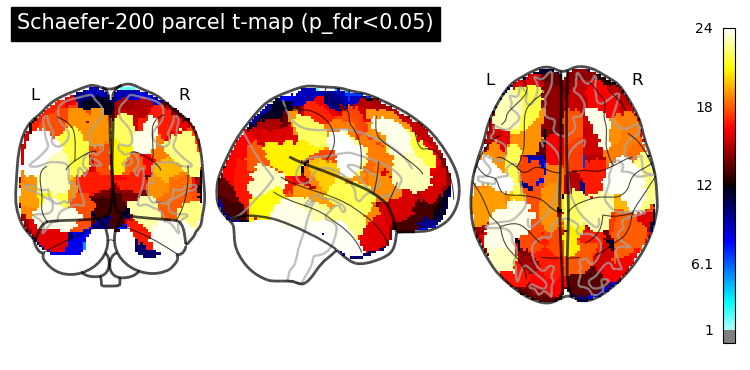

In [25]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import datasets, plotting
from statsmodels.stats.multitest import fdrcorrection

# ─── PARAMETERS ───────────────────────────────────────────────────────────
# must match your nltools snippet
n_rois        = 200
yeo_networks  = 17
resolution_mm = 2
fdr_alpha     = 0.05     # threshold for p_fdr

# input CSV from your group‐level t-test against F=1
group_csv = "/Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/group_F1_stats_with_FDR.csv"

# output map filename
out_nii  = "parcel_t_map_thresholded_pFDR05.nii.gz"

# ─── 1) LOAD & THRESHOLD ─────────────────────────────────────────────────
gr         = pd.read_csv(group_csv)
# grab the full list of t‐stats in parcel order
t_values   = gr.sort_values("parcel_num")["t_stat"].tolist()
# then threshold down to only the significant parcels
thr        = gr[gr["p_fdr"] < fdr_alpha]

# ─── 2) FETCH THE SAME SCHAEFER ATLAS ─────────────────────────────────────
schaefer   = datasets.fetch_atlas_schaefer_2018(
    n_rois=n_rois,
    yeo_networks=yeo_networks,
    resolution_mm=resolution_mm
)
atlas_img  = nib.load(schaefer["maps"])
atlas_data = atlas_img.get_fdata().astype(int)

# sanity check
assert atlas_data.max() == n_rois

# ─── 3) BUILD THE 3D T-STAT MAP ──────────────────────────────────────────
t_map = np.zeros_like(atlas_data, dtype=float)
for _, row in thr.iterrows():
    pid    = int(row["parcel_num"])
    tstat  = float(row["t_stat"])
    t_map[atlas_data == pid] = tstat

# ─── 4) SAVE OUT NIfTI ───────────────────────────────────────────────────
new_img = nib.Nifti1Image(t_map, atlas_img.affine, atlas_img.header)
nib.save(new_img, out_nii)
print("Saved thresholded t-map →", out_nii)

# ─── 5) PLOT (GLASS BRAIN) ────────────────────────────────────────────────
# threshold here means “only show voxels with t > this”
plotting.plot_glass_brain(
    out_nii,
    threshold=1.0,      # you can bump this to 2.0 or 3.0 for more conservative display
    cmap="cold_hot",
    colorbar=True,
    title=f"Schaefer-{n_rois} parcel t-map (p_fdr<{fdr_alpha})"
)
plotting.show() 

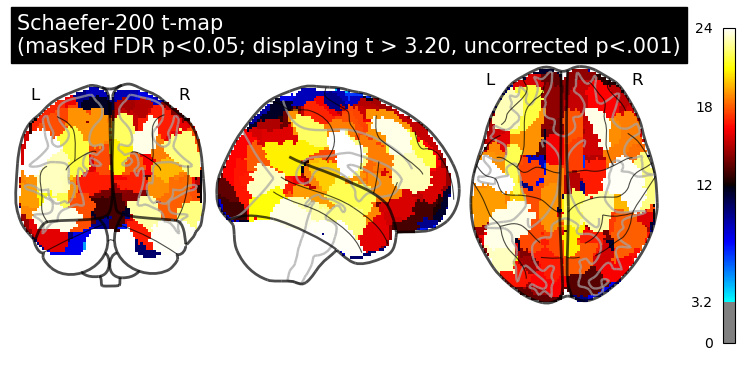

In [28]:
# — compute one‐sided p<.001 threshold for display — 
# df = (# of subject‐run units) – 1
n_units = all_f["unit"].nunique()
df      = n_units - 1
tcrit = stats.t.ppf(1 - 0.001, df) # ~3.30 for df≈74

#  Plot with only t > tcrit (unc. p<.001), but note it’s still FDR‐masked
plotting.plot_glass_brain(
    out_nii,
    threshold=tcrit,
    cmap="cold_hot",
    colorbar=True,
    title=(
      f"Schaefer-{n_rois} t-map\n"
      f"(masked FDR p<{fdr_alpha:.2f}; displaying t > {tcrit:.2f}, uncorrected p<.001)"
    )
)
plotting.show()